In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import wandb
import io
import os
from PIL import Image
from torch.utils.data import Dataset

In [2]:
WANDB_ON = True
SWEEP_ON = True
COUNT = None

In [3]:
class IMDB(Dataset):
    def __init__(self, URL: str = "https://www.imdb.com/chart/top-english-movies", IMG_SIZE: tuple = (44,64)):
        self.URL = URL
        self.IMG_SIZE = IMG_SIZE
        self.transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        page = requests.get(URL)
        soup = BeautifulSoup(page.content, 'html.parser')
        movie_list = soup.find(class_='lister-list')
        movie_elems = movie_list.find_all('tr')
    
        movTitle = []
        movYear = []
        movRating = []
        movPoster = []

        for i, elm in enumerate(movie_elems):
            title = elm.find('td', 'titleColumn').a['title']
            movTitle.append(title)
            year = int(elm.find('td', 'titleColumn').span.string[1:-1])
            movYear.append(year)
            rating = float(elm.find('td', 'ratingColumn imdbRating').strong.string)
            movRating.append(rating)
            posterURL = elm.find('td', 'posterColumn').a.img['src']
            data = requests.get(posterURL).content
            img = Image.open(io.BytesIO(data)).resize(IMG_SIZE)
            array = np.array(img, dtype='uint8')
            movPoster.append(array)
            if i >= 150:
                break

        imdb = {'Movie Title':movTitle, 'Year Published':movYear, 'IMDb Rating':movRating, 'Movie Poster': movPoster}
        self.df = pd.DataFrame(imdb)


    def __len__(self):
        return self.df.shape[0]


    def __getitem__(self, index:int) -> np.ndarray:
        image = self.transform(self.df['Movie Poster'][index])
        return image
    
    def displayImage(self, index:int):
        image = self.df['Movie Poster'][index]
        plt.imshow(image)

In [4]:
if WANDB_ON:
    !wandb login

wandb: Currently logged in as: cmerrill (use `wandb login --relogin` to force relogin)


In [5]:
if WANDB_ON and SWEEP_ON:
    sweep_config = {
        "name": "MovieWeb",
        "method": "bayes",
        "metric": {
            "name": "test_loss",
            "goal": "minimize"
        },
        "parameters": {
            "learning_rate": {
                "distribution": "uniform",
                "min": 0.0001,
                "max": 0.01
            },
            "optimizer": {
                "values": ["Adam"]
            },
            "epochs":{
                "distribution": "normal",
                "mu": 1000,
                "sigma": 250,
            },
            "batch_size": {
                "distribution": "int_uniform",
                "min": 4,
                "max": 256
            },
            "random_seed": {
                "values": [42]
            },
            "validation_split": {
                "values": [.2]
            },
            "shuffle_dataset": {
                "values": [True]
            }
        }
    }

    sweep_id = wandb.sweep(sweep_config, project='MovieWeb', entity='cmerrill')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: n34jyfz0
Sweep URL: https://wandb.ai/cmerrill/MovieWeb/sweeps/n34jyfz0


In [6]:

#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.embedding_size = None
        
        #Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
            
        )
       
        #Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 2, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x) -> torch.Tensor:
        x = self.encoder(x)
        if x.size() != self.embedding_size:
            self.embedding_size = x.size()
        x = self.decoder(x)
        return x

    def embedding(self, x) -> torch.Tensor:
        x = torch.flatten(self.encoder(x), start_dim=1)
        return x

    def count_parameters(self) -> int:
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [7]:
def compression_ratio():
    temp_db = IMDB()
    x = temp_db.__getitem__(0)
    model = ConvAutoencoder()
    x = torch.reshape(x, (1,*x.shape))
    _ = model.forward(x)
    cr = np.prod(x.shape) / np.prod(model.embedding_size)
    return cr

print(f'Compression ratio: {compression_ratio()}:1')

Compression ratio: 12.0:1


In [8]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [9]:
def train():
    # get_device()
    with wandb.init(project='MovieWeb', entity='cmerrill') if WANDB_ON else None as run:
        config = {}
        config['learning_rate'] = 0.1
        config['batch_size'] = 4
        config['epochs'] = 2000
        config['validation_split'] = 0.2
        config['shuffle_dataset'] = True
        config['random_seed'] = 42
        config['optimizer'] = "SGD"
        
        if WANDB_ON:
            config.update(wandb.config)
        
        config['epochs'] = int(config['epochs'])
        print(config)
        
        # Creating data indices for training and validation splits:
        imdbDataset = IMDB()
        dataset_size = len(imdbDataset)
        indices = list(range(dataset_size))
        split = int(np.floor(config['validation_split'] * dataset_size))
        if config['shuffle_dataset'] :
            np.random.seed(config['random_seed'])
            np.random.shuffle(indices)
        train_indices, test_indices = indices[split:], indices[:split]

        # Creating PT data samplers and loaders:
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SubsetRandomSampler(test_indices)

        train_loader = torch.utils.data.DataLoader(
            imdbDataset, 
            batch_size=config['batch_size'], 
            sampler=train_sampler
        )

        test_loader = torch.utils.data.DataLoader(
            imdbDataset, 
            batch_size=config['batch_size'],
            sampler=test_sampler
        )

        #Instantiate the model
        model = ConvAutoencoder()
        model.cuda()

        if WANDB_ON:
            wandb.watch(model)

        #Loss function
        criterion = nn.MSELoss()

        #Optimizer
        optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), lr = config['learning_rate'])

        for epoch in range(1, config['epochs']+1):
            # monitor training loss
            train_loss = 0.0
            
            # Training
            for images in train_loader:
                images = images.cuda()
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, images)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()*images.size(0)
                
            train_loss = train_loss/len(train_loader)
            
            if WANDB_ON:
                wandb.log({"loss": train_loss})

            #monitor testing loss
            test_loss = 0.0

            # Testing
            for images in test_loader:
                images = images.cuda()
                outputs = model(images)
                loss = criterion(outputs, images)
                test_loss += loss.item()*images.size(0)
            
            test_loss = test_loss/len(test_loader)
            
            if WANDB_ON:
                wandb.log({"test_loss": test_loss})

            print('Epoch {} | Train Loss: {:.4f} |  Test Loss: {:.4f}'.format(epoch, train_loss, test_loss))

        #Batch of test images
        dataiter = iter(train_loader)
        images = dataiter.next()
        images = images.cuda()

        #Sample outputs
        outputs = model(images)
        images = images.cpu().data.numpy()
        outputs = outputs.cpu().data.numpy()

        #Original Images
        f, axarr = plt.subplots(1,4,figsize=(12,12))
        for idx in np.arange(4):
            axarr[idx].imshow(np.moveaxis(images[idx], 0, -1))
            axarr[idx].tick_params(
                left=False, 
                right=False , 
                labelleft=False ,
                labelbottom=False, 
                bottom=False
            )
        if WANDB_ON:
            wandb.log({"true_images": plt})
        else:
            plt.show()

        #Reconstructed Images
        f, axarr = plt.subplots(1,4,figsize=(12,12))
        for idx in np.arange(4):
            axarr[idx].imshow(np.moveaxis(outputs[idx], 0, -1))
            axarr[idx].tick_params(
                left=False, 
                right=False , 
                labelleft=False ,
                labelbottom=False, 
                bottom=False
            )

        if WANDB_ON:
            wandb.log({"reconstructed_images": plt})
        else:
            plt.show()

        if WANDB_ON:
            # Save your model.
            torch.save(model.state_dict(), './saved_models/model.pth')
            # Save as artifact for version control.
            artifact = wandb.Artifact(f'model', type='model')
            artifact.add_file('./saved_models/model.pth')
            run.log_artifact(artifact, aliases=['latest', run.name])
            run.join()
            # Delete the file from the saved_models folder.
            os.remove('./saved_models/model.pth')
            run.finish()

wandb: Agent Starting Run: trpab8mv with config:
wandb: 	batch_size: 126
wandb: 	epochs: 678.544985029027
wandb: 	learning_rate: 0.009281543627137394
wandb: 	optimizer: Adam
wandb: 	random_seed: 42
wandb: 	shuffle_dataset: True
wandb: 	validation_split: 0.2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cmerrill (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep
wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'learning_rate': 0.009281543627137394, 'batch_size': 126, 'epochs': 678, 'validation_split': 0.2, 'shuffle_dataset': True, 'random_seed': 42, 'optimizer': 'Adam'}
Epoch 1 | Train Loss: 14.3678 |  Test Loss: 3.6796
Epoch 2 | Train Loss: 14.2898 |  Test Loss: 3.6696
Epoch 3 | Train Loss: 14.2180 |  Test Loss: 3.6547
Epoch 4 | Train Loss: 14.1219 |  Test Loss: 3.6316
Epoch 5 | Train Loss: 13.9968 |  Test Loss: 3.5991
Epoch 6 | Train Loss: 13.8426 |  Test Loss: 3.5532
Epoch 7 | Train Loss: 13.6456 |  Test Loss: 3.4933
Epoch 8 | Train Loss: 13.4033 |  Test Loss: 3.4099
Epoch 9 | Train Loss: 13.1013 |  Test Loss: 3.3089
Epoch 10 | Train Loss: 12.7561 |  Test Loss: 3.1941
Epoch 11 | Train Loss: 12.3389 |  Test Loss: 3.0748
Epoch 12 | Train Loss: 11.8961 |  Test Loss: 2.9346
Epoch 13 | Train Loss: 11.4181 |  Test Loss: 2.7813
Epoch 14 | Train Loss: 10.9014 |  Test Loss: 2.6369
Epoch 15 | Train Loss: 10.3428 |  Test Loss: 2.4548
Epoch 16 | Train Loss: 9.7172 |  Test Loss: 2.2759
Epoch 17 | Tra

loss,1.96201
_runtime,26
_timestamp,1633877694
_step,1357
test_loss,0.48358


loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: xoq5ukrl with config:
wandb: 	batch_size: 105
wandb: 	epochs: 1100.9582830463887
wandb: 	learning_rate: 0.004810698120570477
wandb: 	optimizer: Adam
wandb: 	random_seed: 42
wandb: 	shuffle_dataset: True
wandb: 	validation_split: 0.2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep
wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'learning_rate': 0.004810698120570477, 'batch_size': 105, 'epochs': 1100, 'validation_split': 0.2, 'shuffle_dataset': True, 'random_seed': 42, 'optimizer': 'Adam'}
Epoch 1 | Train Loss: 7.7823 |  Test Loss: 3.8219
Epoch 2 | Train Loss: 7.7040 |  Test Loss: 3.7640
Epoch 3 | Train Loss: 7.5980 |  Test Loss: 3.6802
Epoch 4 | Train Loss: 7.4719 |  Test Loss: 3.5795
Epoch 5 | Train Loss: 7.3191 |  Test Loss: 3.4755
Epoch 6 | Train Loss: 7.1841 |  Test Loss: 3.3778
Epoch 7 | Train Loss: 7.0270 |  Test Loss: 3.2740
Epoch 8 | Train Loss: 6.8444 |  Test Loss: 3.1714
Epoch 9 | Train Loss: 6.6464 |  Test Loss: 3.1004
Epoch 10 | Train Loss: 6.4640 |  Test Loss: 2.9834
Epoch 11 | Train Loss: 6.2572 |  Test Loss: 2.8609
Epoch 12 | Train Loss: 6.0357 |  Test Loss: 2.7543
Epoch 13 | Train Loss: 5.8088 |  Test Loss: 2.6085
Epoch 14 | Train Loss: 5.5588 |  Test Loss: 2.4807
Epoch 15 | Train Loss: 5.2957 |  Test Loss: 2.3548
Epoch 16 | Train Loss: 5.0292 |  Test Loss: 2.2101
Epoch 17 | Train Loss: 4.760

loss,0.88301
_runtime,35
_timestamp,1633877734
_step,2201
test_loss,0.42569


loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Ctrl + C detected. Stopping sweep.


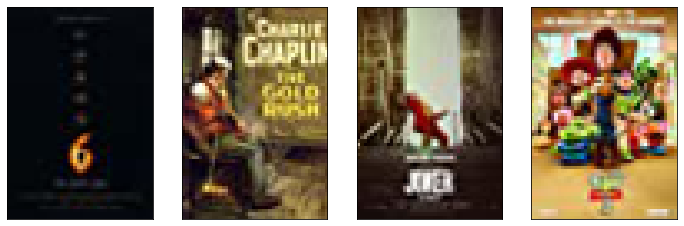

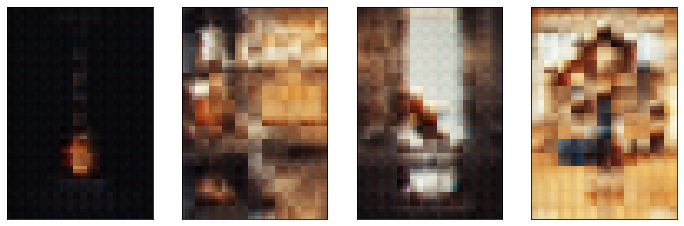

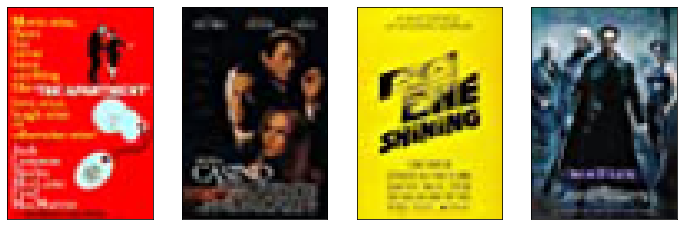

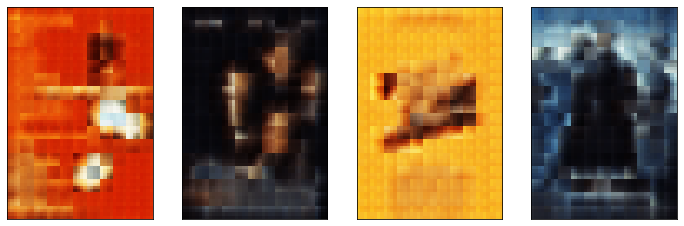

In [10]:
if WANDB_ON:
    if SWEEP_ON:
        wandb.agent(sweep_id, function=train, count=COUNT)
    else:
        train()

- Run all of the data through the model to get the embedding for each poster

In [26]:
def getBestModel():
    api = wandb.Api()

    sweep = api.sweep(f"cmerrill/MovieWeb/{sweep_id}")
    runs = sorted(sweep.runs,
        key=lambda run: run.summary.get("test_loss", 0))
    test_loss = runs[0].summary.get("name", 0)
    print(f"Best run {runs[0].name} with {test_loss} test loss")

    run = wandb.init()
    artifact = run.use_artifact(f'cmerrill/MovieWeb/model:{runs[0].name}', type='model')
    artifact_dir = artifact.download()
    model = ConvAutoencoder()
    checkpoint = torch.load(os.path.join(artifact_dir, 'model.pth'))
    model.load_state_dict(checkpoint)
    
    return model

In [27]:
model = getBestModel()

Best run ruby-sweep-2 with 0 test loss


wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
# fig = plt.figure()
# ax1 = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)

# IMDb_df.plot.scatter("Year Published", "IMDb Rating", ax=ax1)

# lr = LinearRegression().fit(np.array(IMDb_df['Year Published']).reshape(-1,1), np.array(IMDb_df['IMDb Rating']).reshape(-1,1))
# IMDb_df.plot.scatter(x='Year Published', y='IMDb Rating', ax=ax2)
# ax2.plot(np.array(IMDb_df['Year Published']) , lr.predict(np.array(IMDb_df['Year Published']).reshape(-1,1)), color = 'r')
# plt.subplots_adjust(right=1.656)

# plt.show()

In [ ]:
# #def getMetaCritic(URL):

# movie_list = soup.find(class_='clamp-list')

# movie_elems = movie_list.find_all('tr')

# page = Request(url, headers={'User-Agent': 'Mozilla/5.0'})

# webpage = urlopen(page).read()

# soup = BeautifulSoup(webpage, "html.parser")

 

# for elm in movie_elems:
#   try:
#     title = elm.find('td', 'clamp-summary-wrap').find('a', "title").h3.string
#     movTitle.append(title)
#     year = int(elm.find('td', 'clamp-summary-wrap').find('div', 'clamp-details').span.string[-4:])
#     movYear.append(year)
#     rating = float(elm.find('td', 'clamp-summary-wrap').find('div', 'clamp-score-wrap').a.div.string)
#     movRating.append(rating)
#   except AttributeError:
#     continue

# meta = {'Movie Title':movTitle, 'Year Published':movYear, 'Metacritic Rating':movRating}
# pd.DataFrame(meta) #Add Return when converted into Function


# elm.find('td', 'clamp-summary-wrap').find('div', 'clamp-score-wrap').a.div.string

In [ ]:
x = [1,-2,5] 
y = [1,-2,5]
y_bar = sum(y)/len(y) #8.1
x_bar = sum(x)/len(x) #1973.33

In [ ]:
tot = 0
for x_val,y_val in zip(x,y):
  x_var = (x_val - x_bar)* -1
  y_var = (y_val - y_bar)* -1
  tot += x_var * y_var
tot/len(x)

8.222222222222221

In [ ]:
np.dot((np.array(x) - np.average(x)),(np.array(y) - np.average(y)))/np.array(x).shape[0]

8.222222222222221

In [ ]:
a = np.ones((4,7)) + 4

In [ ]:
b = np.ones((3,4)) /2

In [ ]:
np.dot(b, a)

array([[10., 10., 10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10., 10., 10.]])

In [ ]:
x = np.array([1, 5, 4, 7])
y = x * 5 + 7

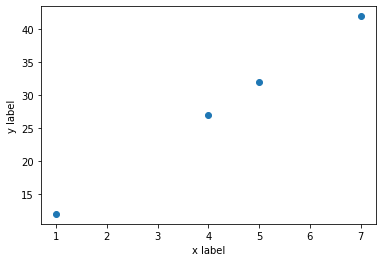

In [ ]:
fig, ax = plt.subplots()
ax.scatter([1, 5, 4, 7], [12, 32, 27, 42])
ax.set_ylabel("y label")
ax.set_xlabel('x label')
plt.show()

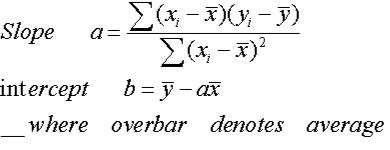

In [ ]:
a_numer = np.dot(x - np.average(x), y - np.average(y))
a_denom = np.dot(x - np.average(x), x - np.average(x))

In [ ]:
a = a_numer/a_denom

In [ ]:
b = np.average(y) - a * np.average(x)

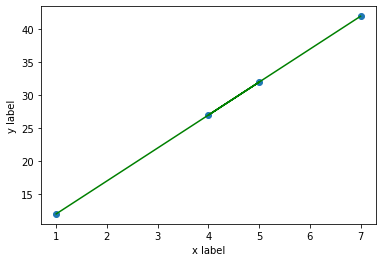

In [ ]:
fig, ax = plt.subplots()
ax.scatter([1, 5, 4, 7], [12, 32, 27, 42])
ax.set_ylabel("y label")
ax.set_xlabel('x label')
plt.plot(x, a*x + b,'g-')
plt.show()

In [ ]:
scaler = StandardScaler()
scaler.fit(x.reshape(-1, 1))
scaler.transform(x.reshape(-1, 1))

array([[-1.5011107 ],
       [ 0.34641016],
       [-0.11547005],
       [ 1.27017059]])

In [ ]:
class Perceptron:

    def __init__(self, no_of_inputs, threshold=100, learning_rate=0.01):
        self.threshold = threshold
        self.learning_rate = learning_rate
        self.weights = np.zeros(no_of_inputs + 1)
           
    def predict(self, inputs):
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
        if summation > 0:
          activation = 1
        else:
          activation = 0            
        return activation

    def train(self, training_inputs, labels):
        for _ in range(self.threshold):
            for inputs, label in zip(training_inputs, labels):
                prediction = self.predict(inputs)
                self.weights[1:] += self.learning_rate * (label - prediction) * inputs
                self.weights[0] += self.learning_rate * (label - prediction)

In [ ]:
listy = [1,2,3]
listx = [3,2,1,0]
for x in zip(listx,listy):
  print(x)

(3, 1)
(2, 2)
(1, 3)


In [ ]:
myPerceptron = Perceptron(4)

In [ ]:
[(3,1), (2,2), (1,3)]

[(3, 1), (2, 2), (1, 3)]

In [ ]:
 summation = np.dot(np.zeros((2,4)), myPerceptron.weights[1:]) + myPerceptron.weights[0]